# Imports

Import all required package

In [1]:
import datetime
import json
import os
import pickle
import time

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.models import Sequential
from keras.preprocessing import image
from PIL import Image, ImageFont
import random

# Load Data

Load data to be augemented, the directory where the data should be should  should 

In [2]:
# the dir containing the sub dir with the classes
dir_aug_data = "./casts/casting_512x512"

#the size of the image more compatiple for training
image_size = (224, 224)

# batch size, the number of image that should be fed into the model during training
batch_size=32

# specify the data "validation" or `training`, in this case both is used 
subset = "both"

# split the data into 70% for training and 30% for validation
validation_split = 0.3

# ensures the data is split the same way every time you run the code by providing a fixed random seed for shuffling.
seed = 123

# Load training and test data from directory
train_data, test_data = keras.utils.image_dataset_from_directory(
    dir_aug_data,
    validation_split=validation_split,
    subset=subset, 
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1300 files belonging to 2 classes.
Using 910 files for training.
Using 390 files for validation.


# Display Data

Display a grid of the data that is been loaded

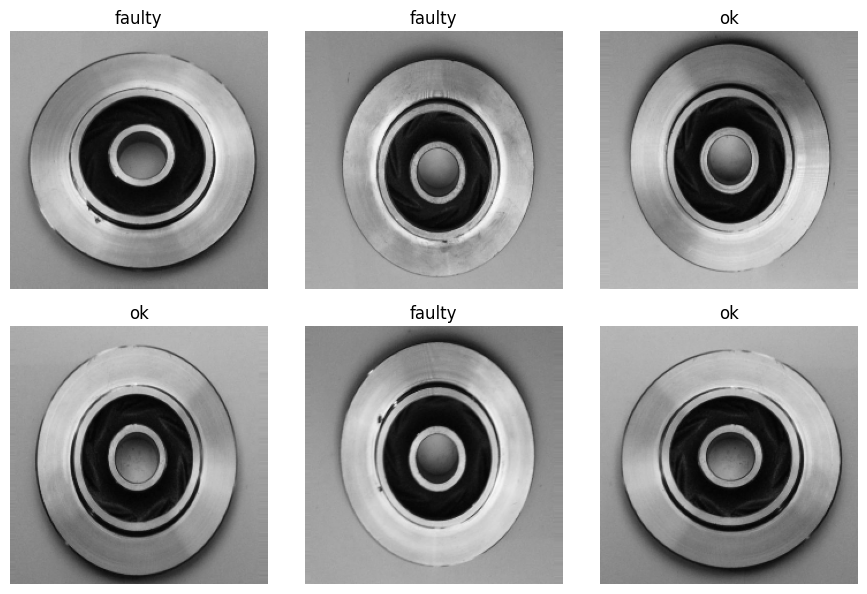

In [3]:
def plot_images(dataset, num_images=4, class_names=None):
    
    # Get a batch of images and labels
    images, labels = next(iter(dataset))

    # Get the batch size for the images
    batch_size = images.shape[0]
    
    # Ensure we don't exceed the batch size when selecting random images
    if batch_size < num_images:
        raise ValueError(f"Batch contains only {batch_size} images, but {num_images} were requested.")
    
    # Plot a figure for the images
    plt.figure(figsize=(9, 9))

    # Select random unique indices from the batch to avoid repetition
    random_indices = np.random.choice(batch_size, num_images, replace=False)
    
    # Plot the selected images
    for i, idx in enumerate(random_indices):
        ax = plt.subplot(3, 3, i + 1)
        
        # Convert image to numpy and display it
        img = images[idx].numpy().astype(np.uint8)
        plt.imshow(img)
        
        # Set the title based on the label
        label = labels[idx].numpy().astype(np.uint8)
        if class_names:
            title = class_names[label]
        else:
            title = f"Class {label}"
        
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Specify class of dataset
class_names = {0: "faulty", 1: "ok"}

# Call function to plot images
plot_images(train_data, num_images=6, class_names=class_names)

# Create augmentation of dataset

Create and display agumentation of dataset, this is to increase the size of data by creating random transformation of the image dataset

Model: "augmentation_layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ ?                      │   0 (unbuilt) │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ ?                      │   0 (unbuilt) │
│ (RandomBrightness)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

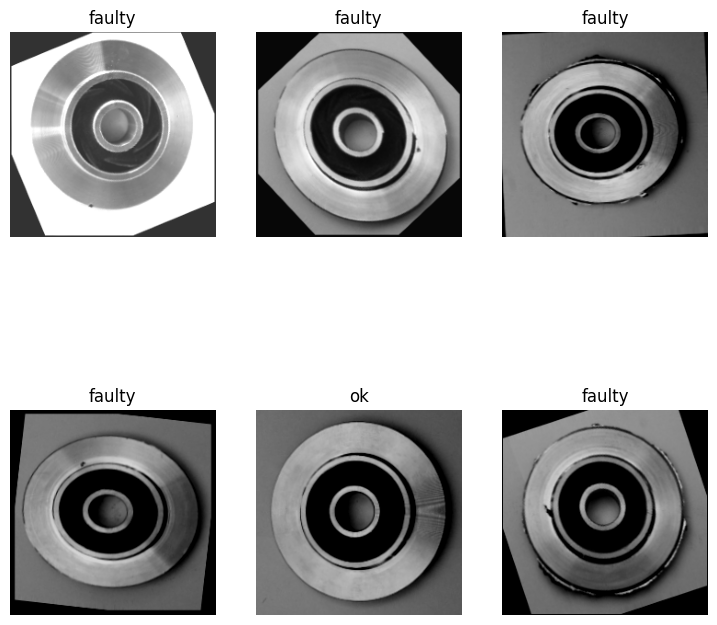

In [4]:
# Create a keras Sequential layer to perform several trasnformations to increase the randomness of the data
data_augmentation = Sequential(
    [
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation((0, 0.9), fill_mode="constant"),
        keras.layers.RandomZoom(0.05, fill_mode="constant"),
        keras.layers.RandomContrast(0.25),
         keras.layers.RandomBrightness(0.25),
    ],
    name="augmentation_layer",
)

data_augmentation.summary()

# get the first batch of image and lable from original_train_data
images, labels = next(iter(train_data))

# Plot a figure for the images
plt.figure(figsize=(9, 9))

# Get size of batch
batch_size = images.shape[0]

# Number of images to display 
num_images = 6

# Select random unique indices from the batch to avoid repetition
random_image_indice = np.random.choice(batch_size, num_images, replace=False)

# loop through images
for count, index in enumerate(random_image_indice):
    augmented_image = data_augmentation(images[index], training=True)
    
    ax = plt.subplot(2, 3, count + 1)
    
    plt.imshow(augmented_image.numpy().astype(np.uint8))

    label = labels[index].numpy().astype(np.uint8)
    
    plt.title(class_names[label])
    
    plt.axis("off")

# Save Augmented Data

save augmented data to disk

In [5]:

def save_augmented_images(data, data_type, path_images, augmentation_count=6):
    """
    Augment an image dataset by performing transformations on the original images.
    Each image is transformed a total of 'augmentation_count' times.
    Note that the training and testing datasets are saved separately to avoid data leakage.
    
    Args:
        - data: image dataset as a BatchDataset
        - data_type: string, type of dataset ('train' or 'test')
        - path_images: string, directory where the images will be saved
        - augmentation_count: int, number of augmentations per image (default: 6)
    """
    
    count_ok, count_faulty = 1, 1
    for batch in data:
        images, labels = batch

        # Enumerate through images and labels
        for i, (image, label) in enumerate(zip(images, labels)):
            label_value = label.numpy()
            
            label_str = class_names[label_value]
            
            count = count_faulty if label_value == 0 else count_ok
            
            label_dir = os.path.join(path_images, data_type, label_str)
            
            # Ensure directory exists
            os.makedirs(label_dir, exist_ok=True)
            
            # Augment the image multiple times
            for j in range(augmentation_count):
                
                try:
                    augmented_image = data_augmentation(image, training=True)
                    img = Image.fromarray(augmented_image.numpy().astype(np.uint8))
                    img_path = os.path.join(label_dir, f"{label_str}_{i}_{j}.jpeg")
                    img.save(img_path)
                    # print(f"creating {label_dir} {label_str}_{i}_{j}.jpeg")
                    
                    
                    # Update the respective counter
                    if label_value == 0:
                        count_faulty += 1
                    else:
                        count_ok += 1

                except Exception as e:
                    print(f"Error saving image {count} of type '{label_str}': {e}")


In [6]:
# Define the main path
path_images = "./augmented_images"


if os.path.exists(path_images):
    print("Data folder already exists")
else:
    print(f"creating augment dir")
    os.makedirs(path_images)

    print("creating (train) dir")
    os.makedirs(os.path.join(path_images, "train"))
    
    print("creating augmented data for (train) ...")
    save_augmented_images(train_data, "train", path_images, augmentation_count=6)
    
    print("creating (test) dir")
    os.makedirs(os.path.join(path_images, "test"))
    
    print("creating augmented data for (test) ...")
    save_augmented_images(test_data, "test", path_images, augmentation_count=6)
      
    print("Done!")

creating augment dir
creating (train) dir
creating augmented data for (train) ...
creating ./augmented_images/train/faulty faulty_0_0.jpeg
creating ./augmented_images/train/faulty faulty_0_1.jpeg
creating ./augmented_images/train/faulty faulty_0_2.jpeg
creating ./augmented_images/train/faulty faulty_0_3.jpeg
creating ./augmented_images/train/faulty faulty_0_4.jpeg
creating ./augmented_images/train/faulty faulty_0_5.jpeg
creating ./augmented_images/train/ok ok_1_0.jpeg
creating ./augmented_images/train/ok ok_1_1.jpeg
creating ./augmented_images/train/ok ok_1_2.jpeg
creating ./augmented_images/train/ok ok_1_3.jpeg
creating ./augmented_images/train/ok ok_1_4.jpeg
creating ./augmented_images/train/ok ok_1_5.jpeg
creating ./augmented_images/train/faulty faulty_2_0.jpeg
creating ./augmented_images/train/faulty faulty_2_1.jpeg
creating ./augmented_images/train/faulty faulty_2_2.jpeg
creating ./augmented_images/train/faulty faulty_2_3.jpeg
creating ./augmented_images/train/faulty faulty_2_4.jp

# Check Saved Data

In [7]:
# Check the size of the images to maker sure it was saved correctly
# Also, check the maximum pixel value to make sure they weren't scaled
# before
image_batch, labels_batch = next(iter(train_data))

print("Image shape is", image_batch[0].numpy().shape)
print("Max pixel values is", np.max(image_batch[0].numpy()))

print("-----")
# Check the size of the batches
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

print("-----")

# Check the number and name of the classes, which is inferred from the
# folder structure
train_data.class_names

Image shape is (224, 224, 3)
Max pixel values is 250.28569
-----
(32, 224, 224, 3)
(32,)
-----


['faulty', 'ok']